In [10]:
!pip install tensorflow

In [12]:
import keras
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from tensorflow.keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.models import model_from_json
from PIL import Image
import numpy as np

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(Image.fromarray(X[k].astype('uint8')))
            k = k+1
    # show the plot
    pyplot.show()

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

# 훈련셋과 시험셋 로딩 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# 라벨링 전환
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# 모델 구성 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#training
batch_size = 64
 
opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
# 모델 학습시키기
hist=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),\
                    callbacks=[TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True),\
                    LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# Load trained CNN model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('model.h5')
 
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[:16]),1)

print([labels[x] for x in indices])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_60 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_60 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_61 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_61 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/125
781/781 [==============================] - 60s 63ms/step - loss: 1.8946 - accuracy: 0.4302 - val_loss: 1.4456 - val_accuracy: 0.5482 - lr: 0.0010
Epoch 2/125
781/781 [==============================] - 50s 64ms/step - loss: 1.2811 - accuracy: 0.5927 - val_loss: 1.2466 - val_accuracy: 0.6218 - lr: 0.0010
Epoch 3/125
781/781 [==============================] - 49s 63ms/step - loss: 1.0834 - accuracy: 0.6516 - val_loss: 0.9585 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 4/125
781/781 [==============================] - 49s 63ms/step - loss: 0.9869 - accuracy: 0.6889 - val_loss: 0.8806 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 5/125
781/781 [==============================] - 48s 62ms/step - loss: 0.9208 - accuracy: 0.7134 - val_loss: 0.8487 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 6/125
781/781 [==============================] - 49s 62ms/step - loss: 0.8740 - accuracy: 0.7305 - val_loss: 0.8669 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 7/125
781/781 [==============================]

In [20]:
print("정확률은",scores[1]*100)

정확률은 89.27000164985657


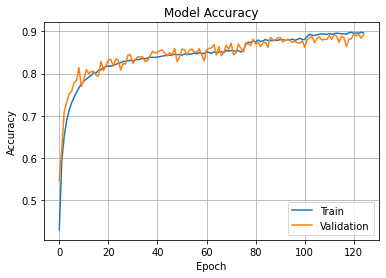

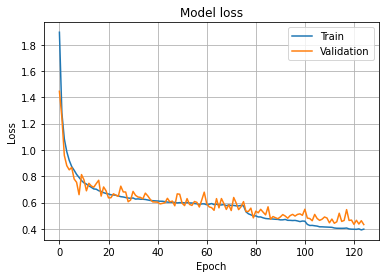

In [16]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

# 손실 함수 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

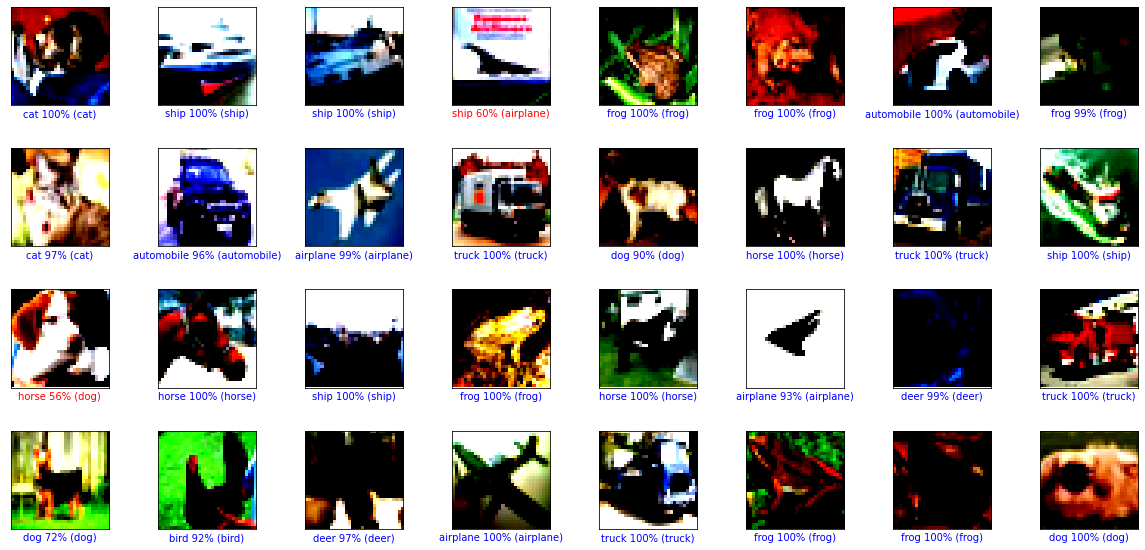

In [17]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"] 
predictions = model.predict(x_test)

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  true_label=np.argmax(true_label)

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

num_rows = 4
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(i, predictions[i], y_test, x_test)
plt.tight_layout()
plt.show()